In [208]:
import pandas as pd
import numpy as np
import os
import psycopg2

# visualization
#import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

from sklearn.grid_search import GridSearchCV

from sklearn import metrics



In [209]:
###Add in login here

In [210]:
def run_query(query, fetchone = False, **params):
	print('Running a Query!')
	conn = psycopg2.connect(host='analytics-redshift.internal.atlassian.com', port=5439, database='dev',user=redshift_username, password=redshift_password)
	cursor = conn.cursor()
	print('Pre Execute')
	cursor.execute(query)
	print('Post Execute')
	if fetchone:
		return cursor.fetchone()
	else:
		return cursor.fetchall()

In [211]:
###
##Read in JIRA data 
###

#2015-09
#jira_data = run_query("with pop as ( SELECT DISTINCT b.tech_email_domain, b.product, b.tech_country, b.parent_sen, b.start_date, b.hosted_url, b.user_limit, (case when products_owned >1 then 1 else 0 end) as products_owned  FROM public.license b  join (select distinct tech_email_domain, min(start_date) as start_date, count(distinct sen) as products_owned from license group by 1) l on b.tech_email_domain=l.tech_email_domain and b.start_date=l.start_date WHERE b.base_product IN ( 'JIRA' , 'JIRA Software' ) AND CURRENT_DATE BETWEEN b.start_date AND b.expiry_date AND b.license_level IN ( 'Starter' , 'Full' ) AND b.platform = 'Cloud' and b.start_date >= '2015-09-01' AND b.start_date <= '2016-07-01') select pop.tech_email_domain, pop.product, tech_country, pop.hosted_url, pop.parent_sen, pop.user_limit, start_date, pop.products_owned , max(case when cp.github>0 or cp.githube>0 then 1 else 0 end) as GH_integrated , count(distinct au.username) as jira_mau   from pop left outer join active_users au on pop.parent_sen=au.parent_sen and au.product = 'jira_software'  and au.metric in ('mau') and au.component in ('returning', 'new', 'resurrected') and au.utc_date >= '2016-09-01' left outer join scratch.connected_products_2016_09 cp on pop.hosted_url=cp.instance group by 1,2,3,4,5,6,7,8")

#2014-2015
jira_data = run_query("with pop as ( SELECT DISTINCT b.tech_email_domain, b.product, b.tech_country, b.parent_sen, b.start_date, b.hosted_url, b.user_limit, (case when products_owned >1 then 1 else 0 end) as products_owned  FROM public.license b  join (select distinct tech_email_domain, min(start_date) as start_date, count(distinct sen) as products_owned from license group by 1) l on b.tech_email_domain=l.tech_email_domain and b.start_date=l.start_date WHERE b.base_product IN ( 'JIRA' , 'JIRA Software' ) AND CURRENT_DATE BETWEEN b.start_date AND b.expiry_date AND b.license_level IN ( 'Starter' , 'Full' ) AND b.platform = 'Cloud' and b.start_date >= '2014-01-01' AND b.start_date <= '2015-12-31') select pop.tech_email_domain, pop.product, tech_country, pop.hosted_url, pop.parent_sen, pop.user_limit, start_date, pop.products_owned , max(case when cp.github>0 or cp.githube>0 then 1 else 0 end) as GH_integrated , count(distinct au.username) as jira_mau   from pop left outer join active_users au on pop.parent_sen=au.parent_sen and au.product = 'jira_software'  and au.metric in ('mau') and au.component in ('returning', 'new', 'resurrected') and au.utc_date >= '2016-09-01' left outer join scratch.connected_products_2016_09 cp on pop.hosted_url=cp.instance group by 1,2,3,4,5,6,7,8")
headers = ["organization","jira","jira_tech_country","hosted_url", "parent_sen", "jira_user_limit", "jira_start_date", "products_owned", "GH_integrated", "jira_mau"]
jira_df = pd.DataFrame(jira_data , columns=headers)

Running a Query!
Pre Execute
Post Execute


In [212]:
jira_df.count()

organization         16557
jira                 16557
jira_tech_country    16557
hosted_url           16557
parent_sen           16557
jira_user_limit      16557
jira_start_date      16557
products_owned       16557
GH_integrated        16557
jira_mau             16557
dtype: int64

In [213]:
jira_df.isnull().sum()


organization         0
jira                 0
jira_tech_country    0
hosted_url           0
parent_sen           0
jira_user_limit      0
jira_start_date      0
products_owned       0
GH_integrated        0
jira_mau             0
dtype: int64

In [214]:
jira_df.jira_start_date.max()

datetime.date(2015, 12, 31)

In [215]:
##
##Read in BB data
##
bb_data = run_query("select distinct tech_email_domain, product, tech_country, count(distinct sen) as num_bb_licenses, min(start_date) as start_date from public.license b  where b.base_product in ('Bitbucket')    AND current_date between start_date and expiry_date  AND b.license_level in ( 'Starter','Full')  AND b.platform = 'Cloud'   group by 1,2,3 order by 1")
headers = ["organization","bitbucket","bb_tech_country","num_bb_licenses", "bb_start_date"]
bb_df = pd.DataFrame(bb_data, columns=headers)

Running a Query!
Pre Execute
Post Execute


In [217]:
bb_df.isnull().sum()


organization        0
bitbucket           0
bb_tech_country    48
num_bb_licenses     0
bb_start_date       0
dtype: int64

In [269]:
##
##Read in Product Owned data
##
#2015-09 data: product_data = run_query("WITH pop AS (SELECT DISTINCT  b.tech_email_domain, l.start_date  FROM public.license b JOIN ( SELECT DISTINCT  tech_email_domain , MIN ( start_date ) AS start_date FROM license  GROUP BY 1 ) l ON b.tech_email_domain = l.tech_email_domain AND b.start_date = l.start_date  WHERE b.base_product IN ( 'JIRA', 'JIRA Software' ) AND CURRENT_DATE BETWEEN b.start_date AND b.expiry_date AND b.license_level IN ( 'Starter', 'Full' ) AND b.platform    = 'Cloud' AND b.start_date >= '2015-09-01' AND b.start_date <= '2016-07-01'  ) select distinct pop.tech_email_domain, count(distinct case when pop.start_date=l.start_date then sen end) as bundled, count(distinct case when base_product='SourceTree' then sen end) as SourceTree, count(distinct case when base_product='Marketplace Addon' then sen end) as Marketplace_Addon, count(distinct case when base_product='Confluence' then sen end) as Confluence, count(distinct case when base_product='JIRA Service Desk' then sen end) as jsd , count(distinct case when base_product='Bamboo' then sen end) as Bamboo, count(distinct case when base_product='Crowd' then sen end) as Crowd, count(distinct case when base_product='HipChat' then sen end) as HC, count(distinct case when base_product='Clover' then sen end) as Clover from pop left outer join license l on pop.tech_email_domain=l.tech_email_domain group by 1;")

#2014-2015
product_data = run_query("WITH pop AS (SELECT DISTINCT  b.tech_email_domain, l.start_date  FROM public.license b JOIN ( SELECT DISTINCT  tech_email_domain , MIN ( start_date ) AS start_date FROM license  GROUP BY 1 ) l ON b.tech_email_domain = l.tech_email_domain AND b.start_date = l.start_date  WHERE b.base_product IN ( 'JIRA', 'JIRA Software' ) AND CURRENT_DATE BETWEEN b.start_date AND b.expiry_date AND b.license_level IN ( 'Starter', 'Full' ) AND b.platform    = 'Cloud' AND b.start_date >= '2014-01-01' AND b.start_date <= '2015-12-31'  ) select distinct pop.tech_email_domain, count(distinct case when pop.start_date=l.start_date then sen end) as bundled, count(distinct case when base_product='SourceTree' then 1 end) as SourceTree, count(distinct case when base_product='Marketplace Addon' then 1 end) as Marketplace_Addon, count(distinct case when base_product='Confluence' then 1 end) as Confluence, count(distinct case when base_product='JIRA Service Desk' then 1 end) as jsd , count(distinct case when base_product='Bamboo' then 1 end) as Bamboo, count(distinct case when base_product='Crowd' then 1 end) as Crowd, count(distinct case when base_product='HipChat' then 1 end) as HC, count(distinct case when base_product='Clover' then 1 end) as Clover from pop left outer join license l on pop.tech_email_domain=l.tech_email_domain group by 1;")
headers = ["organization","purchased_bundled","sourcetree","marketplace_addon","confluence","jsd","bamboo","crowd","hc","clover"]
product_df = pd.DataFrame(product_data, columns=headers)

Running a Query!
Pre Execute
Post Execute


In [770]:
###
##Read in Product Behavior Data
###
behavior_data = run_query("WITH pop AS (SELECT DISTINCT b.tech_email_domain, to_char(l.start_date, 'YYYY-MM') as start_date, b.hosted_url FROM public.license b JOIN (SELECT DISTINCT tech_email_domain, MIN ( start_date ) AS start_date  FROM license GROUP BY 1 ) l ON b.tech_email_domain = l.tech_email_domain AND b.start_date = l.start_date WHERE b.base_product IN ( 'JIRA', 'JIRA Software' ) AND CURRENT_DATE BETWEEN b.start_date AND b.expiry_date AND b.license_level IN ( 'Starter' , 'Full' ) AND b.platform    = 'Cloud' AND b.start_date >= '2015-09-01' and b.start_date  <= '2016-07-01') SELECT DISTINCT pop.tech_email_domain , SUM ( CASE WHEN od.event = 'issuecommented' THEN od.count else 0 END ), SUM (CASE WHEN od.event = 'mentionissuecomment' THEN od.count else 0  END ), SUM (CASE WHEN od.event = 'issuecreated' THEN od.count else 0 END ), SUM (CASE  WHEN od.event = 'projectcreated' THEN od.count else 0 END ), SUM ( CASE WHEN od.event = 'gh.sprint.start' THEN od.count else 0 END ), SUM (CASE  WHEN od.event = 'gh.sprint.complete'  THEN od.count else 0 END ) , SUM ( CASE  WHEN od.event = 'administration.workflow.edit' THEN od.count else 0 END ), SUM (CASE WHEN od.event = 'gh.release.start' THEN od.count  else 0 END )     , SUM (CASE WHEN od.event = 'gh.report.releaseburndown.show' THEN od.count  else 0  END )      , SUM (CASE WHEN od.event = 'versionrelease' THEN od.count  else 0 END )      , SUM (CASE WHEN od.event = 'versioncreate' THEN od.count  else 0 END )      , SUM (CASE WHEN od.event = 'gh.rapidboard.epics.addIssues' THEN od.count  else 0 END )      , SUM (CASE WHEN od.event = 'gh.rapidboard.show.kanban' THEN od.count  else 0 END )      , SUM (CASE WHEN od.event = 'gh.rapidboard.show.scrum' THEN od.count  else 0 END )    FROM pop LEFT OUTER JOIN ondemand_event_summary_month od on pop.hosted_url=od.instance and od.event in   ('issuecommented',  'mentionissuecomment', 'issuecreated', 'projectcreated',  'gh.sprint.start', 'gh.sprint.complete' , 'administration.workflow.edit','gh.release.start','gh.report.releaseburndown.show','versionrelease','versioncreate','gh.rapidboard.epics.addIssues','gh.rapidboard.show.kanban','gh.rapidboard.show.scrum') GROUP BY 1;")
headers = ["organization", "prod_comment","prod_mention","prod_issuecreated","prod_projectcreated","prod_sprintstart","prod_sprintcomplete","prod_workflow","prod_release","prod_releaseburndown","prod_versionrelease","prod_versioncreate","prod_epics","prod_kanban","prod_scrum"]
behavior_df = pd.DataFrame(behavior_data, columns=headers)

Running a Query!
Pre Execute
Post Execute


In [ ]:
###
##Read in marekting channel data
###
marketing_data = run_query("")
headers = ["",""]
marketing_df = pd.DataFrame(marketing_data, columns=headers)

In [313]:
###
##Read in Evaluation data
###
eval_data = run_query("WITH pop AS (SELECT DISTINCT b.tech_email_domain, to_char(l.start_date, 'YYYY-MM') as start_date, b.hosted_url FROM public.license b JOIN (SELECT DISTINCT tech_email_domain, MIN ( start_date ) AS start_date  FROM license GROUP BY 1 ) l ON b.tech_email_domain = l.tech_email_domain AND b.start_date = l.start_date WHERE b.base_product IN ( 'JIRA', 'JIRA Software' ) AND CURRENT_DATE BETWEEN b.start_date AND b.expiry_date AND b.license_level IN ( 'Starter' , 'Full' ) AND b.platform    = 'Cloud' AND b.start_date >= '2015-09-01' and b.start_date  <= '2016-07-01') SELECT DISTINCT pop.tech_email_domain , count ( DISTINCT license_id ) AS bb_evaluations FROM pop LEFT OUTER JOIN evaluation e ON pop.tech_email_domain = e.tech_email_domain  and base_product = 'Bitbucket' GROUP BY 1")
headers = ["organization","bb_evals"]
eval_df = pd.DataFrame(eval_data, columns=headers)

Running a Query!
Pre Execute
Post Execute


In [653]:
###
##Read in Evaluation Score Data
###
eval_score =  pd.read_csv('./Eval_score.csv', encoding='unicode-escape')

pd.set_option('max_colwidth', 500)


In [824]:
##
##Join data together 
##Since we can only run A/B tests in JIRA, I want to only keep if the organization purchased JIRA
##
##
full_data1 = pd.merge(jira_df, bb_df, how='left', on=['organization'])
full_data2 = pd.merge(full_data1,product_df, how='left', on=['organization'] )
full_data3 = pd.merge(full_data2,eval_df, how='left', on=['organization'] )
full_data4 = pd.merge(full_data3,behavior_df, how='left', on=['organization'] )
full_data = pd.merge(full_data4,eval_score, how='left', on=['organization'] )



In [615]:
##Since I limited the JIRA dataframe to only those that landed with JIRA, this should be 0
full_data[full_data.jira_start_date> full_data.bb_start_date].organization.nunique()


0

In [830]:
#Change eval score to floast
full_data.eval_score = full_data.eval_score.convert_objects(convert_numeric=True)
full_data.dtypes

full_data[full_data['eval_score'].isnull()]
full_data.eval_score = full_data.eval_score.fillna(0)


/Users/jhuffman/anaconda/envs/huffmanjh/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  from ipykernel import kernelapp as app


In [845]:
###
##Create dummy variables - probably easier way to do this! 
###

full_data['co_ownership'] = np.where(full_data['bitbucket'] == 'Bitbucket (Cloud)', 1, 0)
full_data['normalized_mau'] = full_data['jira_mau'] / full_data['jira_user_limit']
full_data['bundled'] = np.where(full_data['purchased_bundled'] >=2, 1, 0)
full_data['eval_bb'] = np.where(full_data['bb_evals'] >=1, 1, 0)
full_data['prod_comment'] = np.where(full_data['prod_comment'] >=1, 1, 0)
full_data['prod_mention'] = np.where(full_data['prod_mention'] >=1, 1, 0)
full_data['prod_issuecreated'] = np.where(full_data['prod_issuecreated'] >=1, 1, 0)
full_data['prod_projectcreated'] = np.where(full_data['prod_projectcreated'] >=1, 1, 0)
full_data['prod_sprintstart'] = np.where(full_data['prod_sprintstart'] >=1, 1, 0)
full_data['prod_sprintcomplete'] = np.where(full_data['prod_sprintcomplete'] >=1, 1, 0)
full_data['prod_workflow'] = np.where(full_data['prod_workflow'] >=1, 1, 0)
full_data['prod_release'] = np.where(full_data['prod_release'] >=1, 1, 0)
full_data['prod_releaseburndown'] = np.where(full_data['prod_releaseburndown'] >=1, 1, 0)
full_data['prod_versionrelease'] = np.where(full_data['prod_versionrelease'] >=1, 1, 0)
full_data['prod_versioncreate'] = np.where(full_data['prod_versioncreate'] >=1, 1, 0)
full_data['prod_epics'] = np.where(full_data['prod_epics'] >=1, 1, 0)
full_data['prod_kanban'] = np.where(full_data['prod_kanban'] >=1, 1, 0)
full_data['prod_scrum'] = np.where(full_data['prod_scrum'] >=1, 1, 0)


In [846]:
##Observations 
license_data = full_data[['jira_start_date','jira','jira_user_limit','jira_mau','normalized_mau','GH_integrated','eval_score','bundled','co_ownership']]
license_data

,jira_start_date,jira,jira_user_limit,jira_mau,normalized_mau,GH_integrated,eval_score,bundled,co_ownership
0,2014-10-27,JIRA Software (Cloud),10,3,0.300000,0,0.052945,0,0
1,2015-11-04,JIRA Software (Cloud),10,8,0.800000,0,0.076112,1,1
2,2015-03-04,JIRA Software (Cloud),10,0,0.000000,0,0.076053,1,0
3,2014-05-01,JIRA Software (Cloud),50,16,0.320000,0,0.118175,1,1
4,2014-08-31,JIRA Software (Cloud),10,0,0.000000,0,0.009802,0,0
5,2015-05-11,JIRA Software (Cloud),10,4,0.400000,0,0.022192,0,0
6,2015-11-02,JIRA Software (Cloud),10,4,0.400000,0,0.137785,1,0
7,2014-03-12,JIRA Software (Cloud),50,40,0.800000,1,0.152956,0,0
8,2015-08-29,JIRA Software (Cloud),10,0,0.000000,0,0.106769,0,0
9,2015-08-10,JIRA Software (Cloud),10,0,0.000000,0,0.136150,1,0


In [841]:
##Observations 
behavior_data = full_data[['jira_start_date','normalized_mau','prod_comment','prod_mention','prod_release','prod_epics','prod_kanban','prod_scrum','co_ownership']]
behavior_data

,jira_start_date,normalized_mau,prod_comment,prod_mention,prod_release,prod_epics,prod_kanban,prod_scrum,co_ownership
0,2014-10-27,0.300000,0,0,0,0,0,0,0
1,2015-11-04,0.800000,1,0,1,0,1,1,1
2,2015-03-04,0.000000,0,0,0,0,0,0,0
3,2014-05-01,0.320000,0,0,0,0,0,0,1
4,2014-08-31,0.000000,0,0,0,0,0,0,0
5,2015-05-11,0.400000,0,0,0,0,0,0,0
6,2015-11-02,0.400000,1,0,0,1,0,1,0
7,2014-03-12,0.800000,0,0,0,0,0,0,0
8,2015-08-29,0.000000,0,0,0,0,0,0,0
9,2015-08-10,0.000000,0,0,0,0,0,0,0


In [847]:
##What percent of organizations that land with JIRA expand to BB? 
full_data.describe()


,parent_sen,jira_user_limit,products_owned,GH_integrated,jira_mau,num_bb_licenses,purchased_bundled,sourcetree,marketplace_addon,confluence,...,prod_versionrelease,prod_versioncreate,prod_epics,prod_kanban,prod_scrum,eval_score,co_ownership,normalized_mau,bundled,eval_bb
count,1.656000e+04,16560.000000,16560.000000,16560.000000,16560.000000,1828.000000,16560.000000,16560.000000,16560.000000,16560.000000,...,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000
mean,4.708686e+06,27.121075,0.852174,0.127899,11.900362,1.074398,2.059601,0.280193,0.270652,0.445592,...,0.092452,0.136171,0.081824,0.127355,0.231039,0.091026,0.110386,0.453541,0.667754,0.002536
std,1.059879e+06,69.852437,0.354938,0.333987,23.784615,0.315519,1.139738,0.449107,0.444310,0.497046,...,0.289671,0.342981,0.274104,0.333380,0.421510,0.050294,0.313380,0.441506,0.471033,0.050299
min,3.007906e+06,10.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.700684e+06,10.000000,1.000000,0.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.058073,0.000000,0.100000,0.000000,0.000000
50%,4.749750e+06,10.000000,1.000000,0.000000,5.000000,NaN,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.091750,0.000000,0.400000,1.000000,0.000000
75%,5.674429e+06,15.000000,1.000000,0.000000,12.000000,NaN,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.125963,0.000000,0.700000,1.000000,0.000000
max,6.402288e+06,2000.000000,1.000000,1.000000,463.000000,4.000000,16.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.285092,1.000000,24.000000,1.000000,1.000000


In [848]:
full_data.isnull().sum()


organization                0
jira                        0
jira_tech_country           0
hosted_url                  0
parent_sen                  0
jira_user_limit             0
jira_start_date             0
products_owned              0
GH_integrated               0
jira_mau                    0
bitbucket               14732
bb_tech_country         14735
num_bb_licenses         14732
bb_start_date           14732
purchased_bundled           0
sourcetree                  0
marketplace_addon           0
confluence                  0
jsd                         0
bamboo                      0
crowd                       0
hc                          0
clover                      0
bb_evals                12408
prod_comment                0
prod_mention                0
prod_issuecreated           0
prod_projectcreated         0
prod_sprintstart            0
prod_sprintcomplete         0
prod_workflow               0
prod_release                0
prod_releaseburndown        0
prod_versi

In [274]:
#full_data = full_data[np.isfinite(full_data['prod_comment'])]
#full_data.isnull().sum()

#list(full_data.columns.values)


In [849]:
##Null accuracy Rate
##What percent of organizations that land with JIRA, expand to BB? 11.6%
full_data['co_ownership'].value_counts() / full_data.shape[0]

0    0.889614
1    0.110386
Name: co_ownership, dtype: float64

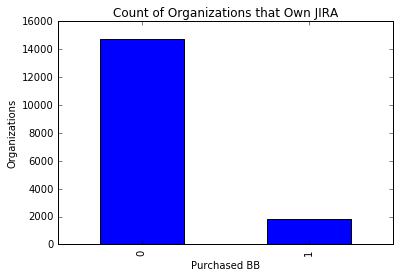

In [853]:
##Show how many organizations we have that have purchased BB and those that have not purchased BB. 
fig= full_data.co_ownership.value_counts().plot(kind='bar')
fig.set_title("Count of Organizations that Own JIRA")
fig.set_xlabel("Purchased BB")
fig.set_ylabel("Organizations")

In [226]:
#######
##Summary of Data
#######

#Unique values of country
#full_data['jira_tech_country'].value_counts()
#full_data['jira_tech_country'].value_counts().plot(kind='bar')


In [612]:
full_data.describe()

,parent_sen,jira_user_limit,products_owned,GH_integrated,jira_mau,num_bb_licenses,purchased_bundled,sourcetree,marketplace_addon,confluence,...,prod_releaseburndown,prod_versionrelease,prod_versioncreate,prod_epics,prod_kanban,prod_scrum,co_ownership,normalized_mau,bundled,eval_bb
count,1.656000e+04,16560.000000,16560.000000,16560.000000,16560.000000,1828.000000,16560.000000,16560.000000,16560.000000,16560.000000,...,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000,16560.000000
mean,4.708686e+06,27.121075,0.852174,0.127899,11.900362,1.074398,2.059601,0.280193,0.270652,0.445592,...,0.048551,0.071739,0.120109,0.077114,0.125785,0.230918,0.110386,0.453541,0.667754,0.000845
std,1.059879e+06,69.852437,0.354938,0.333987,23.784615,0.315519,1.139738,0.449107,0.444310,0.497046,...,0.214933,0.258063,0.325098,0.266780,0.331617,0.421433,0.313380,0.441506,0.471033,0.029065
min,3.007906e+06,10.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.700684e+06,10.000000,1.000000,0.000000,1.000000,NaN,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.100000,0.000000,0.000000
50%,4.749750e+06,10.000000,1.000000,0.000000,5.000000,NaN,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.400000,1.000000,0.000000
75%,5.674429e+06,15.000000,1.000000,0.000000,12.000000,NaN,2.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.700000,1.000000,0.000000
max,6.402288e+06,2000.000000,1.000000,1.000000,463.000000,4.000000,16.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,24.000000,1.000000,1.000000


In [859]:

#full_data.corr()
full_data[['co_ownership','GH_integrated','normalized_mau','bundled','sourcetree','bamboo']].corr()

#full_data[['co_ownership','prod_sprintcomplete','prod_workflow','prod_versionrelease','prod_epics','prod_kanban','prod_scrum']].corr()


,co_ownership,GH_integrated,normalized_mau,bundled,sourcetree,bamboo
co_ownership,1.000000,-0.076046,0.135003,0.141695,0.286117,0.199331
GH_integrated,-0.076046,1.000000,0.111278,0.080881,0.042899,0.031682
normalized_mau,0.135003,0.111278,1.000000,0.083310,0.130565,0.055763
bundled,0.141695,0.080881,0.083310,1.000000,0.134065,0.124010
sourcetree,0.286117,0.042899,0.130565,0.134065,1.000000,0.175737
bamboo,0.199331,0.031682,0.055763,0.124010,0.175737,1.000000


In [860]:
full_data.groupby('co_ownership')['jira_user_limit','products_owned','bundled','GH_integrated','normalized_mau','sourcetree','bamboo'].mean()


,jira_user_limit,products_owned,bundled,GH_integrated,normalized_mau,sourcetree,bamboo
co_ownership,,,,,,,
0,25.255906,0.833831,0.644244,0.136845,0.432546,0.234931,0.050638
1,42.152626,1.000000,0.857221,0.055799,0.622744,0.644967,0.211160


In [229]:
full_data.groupby('co_ownership')['jira_user_limit','products_owned','bundled','GH_integrated','normalized_mau','sourcetree','bamboo'].agg([np.min, np.max])



jira_user_limit       products_owned      bundled       \
                        amin  amax           amin amax    amin amax   
co_ownership                                                          
0                         10  2000              0    1       1    1   
1                         10   500              1    1       1    1   

             GH_integrated      normalized_mau            sourcetree       \
                      amin amax           amin       amax       amin amax   
co_ownership                                                                
0                        0    1            0.0  24.000000          0    1   
1                        0    1            0.0   4.733333          0    1   

             bamboo       
               amin amax  
co_ownership              
0                 0    1  
1                 0    1

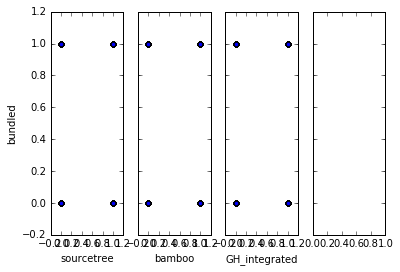

In [489]:
fig, axs = plt.subplots(1, 4, sharey=True)
full_data.plot(kind='scatter', x='prod_scrum', y='prod_workflow', ax=axs[0])
full_data.plot(kind='scatter', x='sourcetree', y='bundled', ax=axs[0])
full_data.plot(kind='scatter', x='bamboo', y='bundled', ax=axs[1])
full_data.plot(kind='scatter', x='GH_integrated', y='co_ownership', ax=axs[2])

In [231]:
#pd.scatter_matrix(full_data, figsize=(10,10))


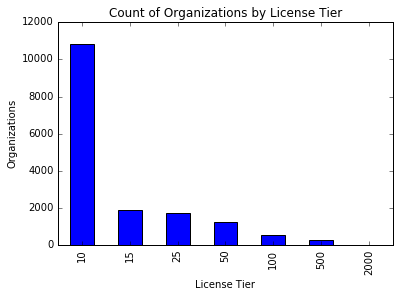

In [492]:
fig = full_data.jira_user_limit.value_counts().plot(kind='bar')
fig.set_title("Count of Organizations by License Tier")
fig.set_xlabel("License Tier")
fig.set_ylabel("Organizations")

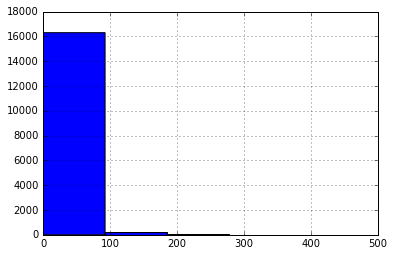

In [494]:
full_data.jira_mau.hist(bins=5)


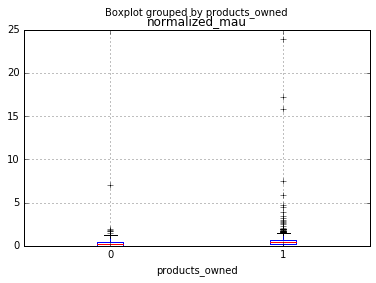

In [495]:
full_data.boxplot(column='normalized_mau', by='products_owned')


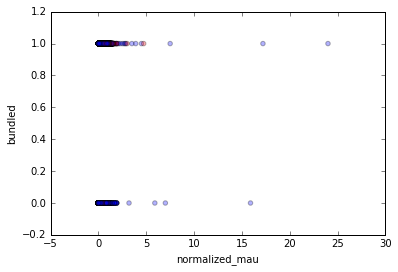

In [496]:
colors = np.where(full_data.co_ownership==1, 'r', 'b')
full_data.plot(x='normalized_mau', y='bundled', kind='scatter', alpha=0.3, c=colors) 



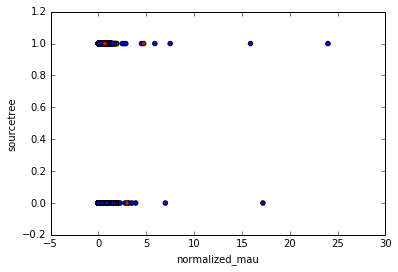

In [499]:
##Show the distrubution of JIRA MAU split by co-ownership
#This shows the relationship between the predictor, MAU, and the response, co-ownership

colors = np.where(full_data.co_ownership==1, 'r', 'b')

#full_data.plot(x='jira_mau', y='bundled', kind='scatter', c=colors) 

full_data.plot(x='normalized_mau', y='sourcetree', kind='scatter', c=colors) 

#full_data.plot(x='sourcetree', y='bundled', kind='scatter', c=colors) 



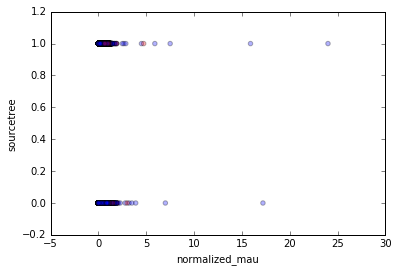

In [237]:
colors = np.where(full_data.co_ownership==1, 'r', 'b')
full_data.plot(x='normalized_mau', y='sourcetree', kind='scatter', alpha=0.3, c=colors) 


In [320]:
full_data.groupby('co_ownership').describe()


GH_integrated        bamboo     bb_evals       bundled  \
co_ownership                                                                 
0            count   14732.000000  14732.000000  3864.000000  14732.000000   
             mean        0.136845      0.050638     0.014752      0.644244   
             std         0.343695      0.219265     0.219523      0.478758   
             min         0.000000      0.000000     0.000000      0.000000   
             25%         0.000000      0.000000          NaN      0.000000   
             50%         0.000000      0.000000          NaN      1.000000   
             75%         0.000000      0.000000          NaN      1.000000   
             max         1.000000      1.000000    10.000000      1.000000   
1            count    1828.000000   1828.000000   288.000000   1828.000000   
             mean        0.055799      0.211160     0.038194      0.857221   
             std         0.229595      0.408243     0.240353      0.349943   
             min         0.000000      0.000000     0.000000      0.000000   
             25%         0.000000      0.000000          NaN      1.000000   
             50%         0.000000      0.000000          NaN      1.000000   
             75%         0.000000      0.000000          NaN      1.000000   
             max         1.000000      1.000000     2.000000      1.000000   

                          clover    confluence         crowd       eval_bb  \
co_ownership                                                                 
0            count  14732.000000  14732.000000  14732.000000  14732.000000   
             mean       0.000136      0.420649      0.001290      0.000747   
             std        0.011651      0.493680      0.035891      0.027316   
             min        0.000000      0.000000      0.000000      0.000000   
             25%        0.000000      0.000000      0.000000      0.000000   
             50%        0.000000      0.000000      0.000000      0.000000   
             75%        0.000000      1.000000      0.000000      0.000000   
             max        1.000000      1.000000      1.000000      1.000000   
1            count   1828.000000   1828.000000   1828.000000   1828.000000   
             mean       0.000547      0.646608      0.003829      0.001641   
             std        0.023389      0.478154      0.061780      0.040489   
             min        0.000000      0.000000      0.000000      0.000000   
             25%        0.000000      0.000000      0.000000      0.000000   
             50%        0.000000      1.000000      0.000000      0.000000   
             75%        0.000000      1.000000      0.000000      0.000000   
             max        1.000000      1.000000      1.000000      1.000000   

                              hc      jira_mau  jira_user_limit           jsd  \
co_ownership                                                                    
0            count  14732.000000  14732.000000     14732.000000  14732.000000   
             mean       0.001290     10.834374        25.255906      0.143633   
             std        0.035891     22.546001        66.344972      0.350729   
             min        0.000000      0.000000        10.000000      0.000000   
             25%        0.000000      1.000000        10.000000      0.000000   
             50%        0.000000      5.000000        10.000000      0.000000   
             75%        0.000000     11.000000        15.000000      0.000000   
             max        1.000000    463.000000      2000.000000      1.000000   
1            count   1828.000000   1828.000000      1828.000000   1828.000000   
             mean       0.001094     20.491247        42.152626      0.222648   
             std        0.033068     30.752387        92.084967      0.416138   
             min        0.000000      0.000000        10.000000      0.000000   
             25%        0.000000      6.000000        10.000000      0.00000

In [861]:
#import seaborn as sns
#help
sns.pairplot(full_data, x_vars=['normalized_mau','GH_integrated','products_owned','bundled','sourcetree','marketplace_addon','confluence','jsd','bamboo','crowd','hc','clover'], y_vars='co_ownership', size=6, aspect=0.7, kind='reg')
sns.pairplot(full_data)



In [321]:
print full_data.co_ownership.describe()
print full_data.co_ownership.value_counts()
print full_data.co_ownership.isnull().sum()


count    16560.000000
mean         0.110386
std          0.313380
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: co_ownership, dtype: float64
0    14732
1     1828
Name: co_ownership, dtype: int64
0


In [782]:
#####
#####
##Create X and y variables 
#####
#####
# 

#feature_cols = full_data[['normalized_mau','GH_integrated','products_owned','bundled','sourcetree','marketplace_addon','confluence','jsd','bamboo','crowd','hc','clover','eval_bb','prod_comment','prod_mention','prod_issuecreated','prod_projectcreated','prod_sprintstart','prod_sprintcomplete','prod_workflow','prod_release','prod_releaseburndown','prod_versionrelease','prod_versioncreate','prod_epics','prod_kanban','prod_scrum']]
##Changed to only important features 
#feature_cols = ['normalized_mau','GH_integrated','bundled','sourcetree','bamboo','eval_score']

feature_cols = ['normalized_mau','GH_integrated','products_owned','bundled','sourcetree','marketplace_addon','confluence','jsd','bamboo','crowd','hc','clover','eval_bb','prod_comment','prod_mention','prod_issuecreated','prod_projectcreated','prod_sprintstart','prod_sprintcomplete','prod_workflow','prod_release','prod_releaseburndown','prod_versionrelease','prod_versioncreate','prod_epics','prod_kanban','prod_scrum']

X = full_data[feature_cols]
y = full_data['co_ownership']


In [784]:
####
##Fit a KNN model 
##
####
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier 



In [785]:
###
###Knn
### null= .8896
###
knn = KNeighborsClassifier(n_neighbors=58)

from sklearn.cross_validation import cross_val_score
print cross_val_score(knn, X, y, cv=10, scoring='accuracy').mean()
print cross_val_score(knn, X, y, cv=10, scoring='roc_auc').mean()

#This does the same thing: 
#scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
#scores
#np.mean(scores)

# the score function will return the accuracy of your prediction
# Accuracy= the number of correct predictions / the number of rows

0.891666614237
0.798042291933


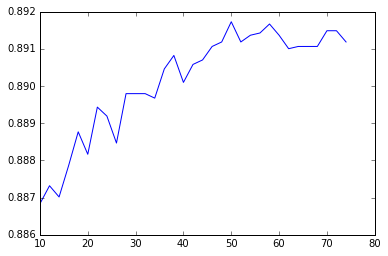

In [863]:
####
####Find the best k --> k=50
####

k_range = range(10, 75, 2)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores.append(np.mean(cross_val_score(knn, X, y, cv=10, scoring='accuracy')))
scores

# plot the K values (x-axis) versus the 10-fold CV score (y-axis)
import matplotlib.pyplot as plt
plt.figure()
plt.plot(k_range, scores)

In [864]:
# automatic grid search for an optimal value of K
from sklearn.grid_search import GridSearchCV
knn = KNeighborsClassifier()
k_range = range(10, 75, 2)
param_grid = dict(n_neighbors=k_range)
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X, y)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74]},
       pre_dispatch='2*n_jobs', refit=True, scoring='accuracy', verbose=0)

In [865]:
# check the results of the grid search
grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]

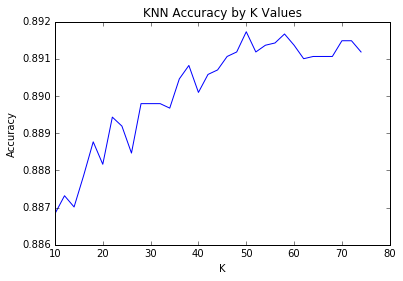

In [866]:
# plot the results
plt.figure()
plt.plot(k_range, grid_mean_scores)
plt.ylabel("Accuracy")
plt.xlabel("K")
plt.title("KNN Accuracy by K Values")

In [867]:
grid.best_score_   

0.89172705314009659

In [868]:
grid.best_params_    # this shows the optimal parameters

{'n_neighbors': 50}

In [793]:
grid.best_estimator_ 

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=50, p=2,
           weights='uniform')

In [697]:
#Print the accuracy of predicting BB co ownership using each column individually
#This will tell us the relationship between the X and Y 
#Each feature predicts the null accuracy 

####
##Iterative Feature Selection
####

for column in X.columns:
    X_subset = X[[column]]
    knn = KNeighborsClassifier(n_neighbors=48)
    knn.fit(X_subset, y)
    print column, "accuracy:", knn.score(X_subset, y)

normalized_mau accuracy: 0.88961352657
GH_integrated accuracy: 0.88961352657
bundled accuracy: 0.88961352657
sourcetree accuracy: 0.88961352657
bamboo accuracy: 0.88961352657
eval_score accuracy: 0.88961352657


In [869]:
knn = KNeighborsClassifier(n_neighbors=50)
knn.fit(X, y)
knn.score(X, y)

0.89227053140096624

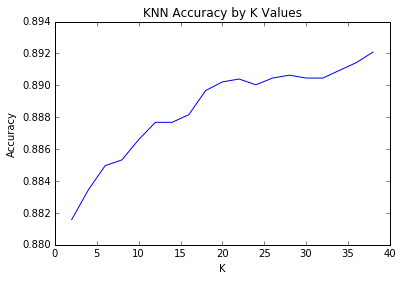

In [798]:
#Removing some features....  
#automatic grid search for an optimal value of K
from sklearn.grid_search import GridSearchCV
knn = KNeighborsClassifier()
k_range = range(2, 40, 2)
param_grid = dict(n_neighbors=k_range)
X_subset = full_data[['normalized_mau','GH_integrated','products_owned','bundled','bamboo','sourcetree']]
grid = GridSearchCV(knn, param_grid, cv=10, scoring='accuracy')
grid.fit(X_subset, y)

grid.grid_scores_
grid_mean_scores = [result[1] for result in grid.grid_scores_]

plt.figure()
plt.plot(k_range, grid_mean_scores)
plt.ylabel("Accuracy")
plt.xlabel("K")
plt.title("KNN Accuracy by K Values")

In [372]:
pipe = make_pipeline(SelectKBest(k=5), KNeighborsClassifier(n_neighbors=3))
cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()

0.88345409769235916

In [799]:
#####
#####
### Fit a logistic regression model and examine the coefficients to confirm that they make intuitive sense.
#####Using this model, instead of a linear model, tells us the probablity of predicting Y, given X
#####
from sklearn.linear_model import LogisticRegression
#import sklearn.linear_model as lm

logreg = LogisticRegression()



In [870]:
print cross_val_score(logreg, X, y, cv=5, scoring='accuracy').mean()
print cross_val_score(logreg, X, y, cv=5, scoring='roc_auc').mean()


0.892149458838
0.811747855702


In [802]:
#####
##Select K best
####
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline, make_union
from sklearn.feature_selection import SelectKBest

logreg = LogisticRegression()
filter1 = SelectKBest(k=2) # select the best 2 features
pipe = Pipeline([('anova', filter1), ('logistic', logreg)])


mean = cross_val_score(pipe, X, y, cv=5, scoring='accuracy').mean()
mean

/Users/jhuffman/anaconda/envs/huffmanjh/lib/python2.7/site-packages/sklearn/feature_selection/univariate_selection.py:113: UserWarning: Features [3] are constant.
  UserWarning)


0.88961355498697137

In [803]:
easy_pipe = make_pipeline(SelectKBest(k=3), LogisticRegression())
mean = cross_val_score(easy_pipe, X, y, cv=5, scoring='accuracy').mean()
mean

0.88961355498697137

In [804]:
#####
##Naive Bayes model
##Performed worst than logistic and knn
#####

from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

print cross_val_score(nb, X, y, cv=10, scoring='accuracy').mean()
print cross_val_score(nb, X, y, cv=10, scoring='roc_auc').mean()





0.885447171245
0.732699240278


In [710]:
######
###Decision Tree
######

In [871]:
##Classification Decision Tree
from sklearn.tree import DecisionTreeClassifier
treeclf = DecisionTreeClassifier(max_depth=4, random_state=1)
treeclf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [872]:
#Print the decision tree
from sklearn.tree import export_graphviz
export_graphviz(treeclf, out_file='tree_atlassian2.dot', feature_names=feature_cols)

#In terminal: dot -Tpng tree_titanic.dot -o tree_titanic.png

In [876]:
##Importance
treeclf_features = pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})
treeclf_features.sort_values(['importance'], ascending=[0])


,feature,importance
4,sourcetree,0.536929
0,normalized_mau,0.168790
8,bamboo,0.144221
1,GH_integrated,0.121312
2,products_owned,0.028747
16,prod_projectcreated,0.000000
25,prod_kanban,0.000000
24,prod_epics,0.000000
23,prod_versioncreate,0.000000
22,prod_versionrelease,0.000000


In [808]:
# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.cross_validation import cross_val_score
for depth in max_depth_range:
    treereg = DecisionTreeClassifier(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [809]:
sorted(zip(RMSE_scores, max_depth_range))[0]


(0.32802139658827811, 4)

In [810]:
# list of values to try for max_depth
max_depth_range = range(1, 21)

# list to store the average RMSE for each value of max_depth
RMSE_scores = []

# use 10-fold cross-validation with each value of max_depth
from sklearn.cross_validation import cross_val_score
for depth in max_depth_range:
    treereg = DecisionTreeClassifier(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=10, scoring='accuracy').mean()
    RMSE_scores.append(MSE_scores)

In [811]:
sorted(zip(RMSE_scores, max_depth_range))[0]


(0.86757317440057702, 20)

In [812]:
print cross_val_score(treereg, X, y, cv=10, scoring='roc_auc').mean()

0.658046912842


In [813]:
treereg = DecisionTreeClassifier(max_depth=5, random_state=1)
treereg.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [814]:
treereg = DecisionTreeClassifier(max_depth=19, random_state=1)
treereg.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=19,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1, splitter='best')

In [815]:
treeclf_features = pd.DataFrame({'feature':feature_cols, 'importance':treeclf.feature_importances_})
treeclf_features.sort(['importance'], ascending=[0])

/Users/jhuffman/anaconda/envs/huffmanjh/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,feature,importance
4,sourcetree,0.502350
0,normalized_mau,0.177118
8,bamboo,0.134933
1,GH_integrated,0.128795
2,products_owned,0.026895
6,confluence,0.013089
5,marketplace_addon,0.011404
7,jsd,0.002830
15,prod_issuecreated,0.001846
20,prod_release,0.000739


In [ ]:
#####
#####
#####
##Random Forest 
####
#####
#####

In [816]:
#####
##Random Forest 
####
from sklearn.ensemble import RandomForestClassifier
rfreg = RandomForestClassifier()
rfreg

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [817]:
# list of values to try for n_estimators
estimator_range = range(10, 310, 10)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators (WARNING: SLOW!)
for estimator in estimator_range:
    rfreg = RandomForestRegressor(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='mean_squared_error')
    RMSE_scores.append(np.mean(np.sqrt(-MSE_scores)))

In [818]:
sorted(zip(RMSE_scores, estimator_range))[0]


(0.31071198037397296, 250)

In [ ]:
# list of values to try for n_estimators
estimator_range = range(1, 5000, 50)

# list to store the average RMSE for each value of n_estimators
RMSE_scores = []

# use 5-fold cross-validation with each value of n_estimators 
for estimator in estimator_range:
    rfreg = RandomForestClassifier(n_estimators=estimator, random_state=1)
    MSE_scores = cross_val_score(rfreg, X, y, cv=5, scoring='accuracy').mean()
    RMSE_scores.append(MSE_scores)

In [820]:
#CV 5 (0.87318797722564168, 50)
#CV 10 (0.87397410418493726, 200)

sorted(zip(RMSE_scores, estimator_range))[0]



(0.8742150213664367, 10)

In [883]:
rfreg = RandomForestClassifier(n_estimators=2000)
print cross_val_score(rfreg, X, y, cv=10, scoring='accuracy').mean()
print cross_val_score(rfreg, X, y, cv=10, scoring='roc_auc').mean()

0.876509899146
0.740745084445


In [822]:
rfreg = RandomForestClassifier(n_estimators=50, oob_score=True, random_state=1)
rfreg.fit(X, y)

rfreg_features = pd.DataFrame({'feature':feature_cols, 'importance':rfreg.feature_importances_})
rfreg_features.sort(['importance'], ascending=[0])

/Users/jhuffman/anaconda/envs/huffmanjh/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
0,normalized_mau,0.536816
4,sourcetree,0.127343
8,bamboo,0.061000
1,GH_integrated,0.039781
6,confluence,0.036156
5,marketplace_addon,0.030529
7,jsd,0.024074
2,products_owned,0.018063
24,prod_epics,0.014541
21,prod_releaseburndown,0.013092


In [823]:
clf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, random_state=0)
scores = cross_val_score(clf, X, y)
scores.mean() 

0.87433550538664051